# Minimal QNN (Angle Encoding) - Linear Toy Dataset

Goal: Implement a minimal variational quantum classifier (QNN) for a linearly separable 2D dataset.
We use:
- 2 qubits (one per feature)
- fixed Angle Encoding
- a small trainable variational ansatz
- expectation value $\langle Z_0\rangle$ as prediction
- classical optimization (COBYLA)

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
import sys

from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, SparsePauliOp

from scipy.optimize import minimize

PROJECT_ROOT = Path(os.getcwd()).resolve().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src.encodings import AngleEncoding

GLOBAL_SEED = 0
rng = np.random.default_rng(GLOBAL_SEED)

RESULTS_DIR = PROJECT_ROOT / "results" / "qnn"
RESULTS_DIR.mkdir(exist_ok=True)
CIRCUITS_DIR = RESULTS_DIR / "circuits"
CIRCUITS_DIR.mkdir(parents=True, exist_ok=True)

In [23]:
def make_linear_toy(n=200, seed=0, noise=0.25):
    rng = np.random.default_rng(seed)

    n0 = n // 2
    n1 = n - n0

    c0 = np.array([-1.0, -1.0])
    c1 = np.array([+1.0, +1.0])

    X0 = c0 + rng.normal(scale=noise, size=(n0, 2))
    X1 = c1 + rng.normal(scale=noise, size=(n1, 2))

    X = np.vstack([X0, X1])
    y = np.hstack([ -np.ones(n0), +np.ones(n1) ])  # labels in {-1, +1}

    # Shuffle
    idx = rng.permutation(n)
    return X[idx], y[idx]

X, y = make_linear_toy(n=200, seed=GLOBAL_SEED, noise=0.30)

# standardize features
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_std[X_std == 0] = 1.0
Xn = (X - X_mean) / X_std

print("Xn shape:", Xn.shape, "| y shape:", y.shape)

Xn shape: (200, 2) | y shape: (200,)


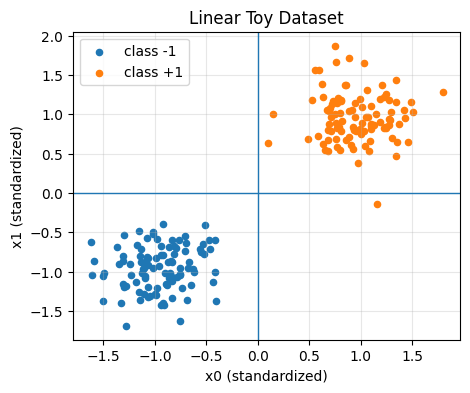

In [24]:
plt.figure(figsize=(5, 4))
plt.scatter(Xn[y == -1, 0], Xn[y == -1, 1], s=20, label="class -1")
plt.scatter(Xn[y == +1, 0], Xn[y == +1, 1], s=20, label="class +1")
plt.axhline(0, linewidth=1)
plt.axvline(0, linewidth=1)
plt.xlabel("x0 (standardized)")
plt.ylabel("x1 (standardized)")
plt.title("Linear Toy Dataset")
plt.legend()
plt.grid(alpha=0.3)
plt.savefig(RESULTS_DIR / "dataset_linear.png")
plt.show()

## Model definition

We define a minimal QNN:
1) Encode the 2D input $x$ via Angle Encoding (fixed, no trainable parameters).
2) Apply a small trainable variational ansatz $U(\theta)$.
3) Measure the expectation value $\langle Z_0\rangle$ which lies in $[-1, 1]$.
4) Train $\theta$ to minimize MSE between prediction $\langle Z_0\rangle$ and labels in $\{-1, +1\}$.

In [25]:
encoder = AngleEncoding()

def ansatz(theta):
    """
    Small 2-qubit hardware-efficient ansatz.
    theta: array of shape (4,)
    """
    qc = QuantumCircuit(2)
    qc.ry(float(theta[0]), 0)
    qc.ry(float(theta[1]), 1)
    qc.cx(0, 1)
    qc.ry(float(theta[2]), 0)
    qc.ry(float(theta[3]), 1)
    return qc

theta_test = rng.uniform(-0.2, 0.2, size=4)
qc_test = encoder.circuit(Xn[0])
qc_test.compose(ansatz(theta_test), inplace=True)
fig = qc_test.draw(output="mpl")
fig.savefig(CIRCUITS_DIR / "circuit_angle.png")
print(qc_test.draw(output="text"))

        ┌────────┐   ┌──────────────┐     ┌──────────────┐
q_0: ───┤ Ry(-π) ├───┤ Ry(0.054785) ├──■──┤ Ry(-0.18361) ├
     ┌──┴────────┴─┐┌┴──────────────┤┌─┴─┐├──────────────┤
q_1: ┤ Ry(-2.5257) ├┤ Ry(-0.092085) ├┤ X ├┤ Ry(-0.19339) ├
     └─────────────┘└───────────────┘└───┘└──────────────┘


In [26]:
Z0 = SparsePauliOp.from_list([("ZI", 1.0)])

def expectation_value(qc, observable):
    """
    Exact expectation value using statevector simulation.
    """
    sv = Statevector.from_instruction(qc)
    return float(np.real(sv.expectation_value(observable)))

def predict_value(x, theta):
    """
    Prediction in [-1, 1] via ⟨Z0⟩.
    """
    qc = encoder.circuit(x)
    qc.compose(ansatz(theta), inplace=True)
    return expectation_value(qc, Z0)

def predict_label(x, theta):
    return +1 if predict_value(x, theta) >= 0 else -1

print("pred value:", predict_value(Xn[0], theta_test), "true:", y[0])

pred value: 0.7523470018075752 true: -1.0


In [27]:
def loss(theta, X, y):
    """
    Mean squared error between prediction ⟨Z0⟩ and labels in {-1, +1}.
    """
    preds = np.array([predict_value(x, theta) for x in X], dtype=float)
    return float(np.mean((preds - y) ** 2))

print("loss(theta_test):", loss(theta_test, Xn[:20], y[:20]))

loss(theta_test): 1.5568723681937144


In [28]:
theta0 = rng.uniform(-0.1, 0.1, size=4)

loss_history = []
def callback(theta_k):
    loss_history.append(loss(theta_k, Xn, y))

res = minimize(
    fun=lambda th: loss(th, Xn, y),
    x0=theta0,
    method="COBYLA",
    callback=callback,
    options={"maxiter": 100}
)

theta_star = res.x
print("Optimization success:", res.success)
if not res.success:
    print(f"\t{res.message}")
    print(f"\tnfev:   {res.nfev}")

print("Final loss:", loss(theta_star, Xn, y))

Optimization success: False
	Maximum number of function evaluations has been exceeded.
	nfev:   100
Final loss: 0.3517109095065824


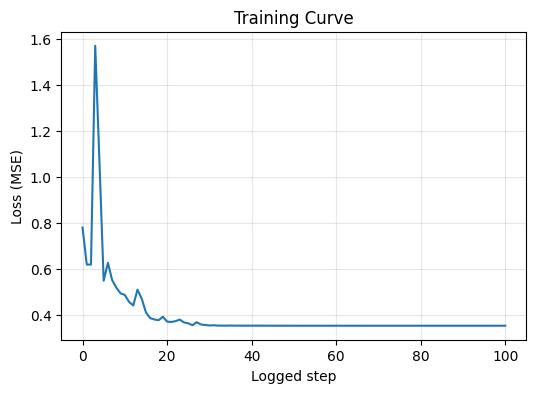

In [29]:
plt.figure(figsize=(6, 4))
plt.plot(loss_history)
plt.xlabel("Logged step")
plt.ylabel("Loss (MSE)")
plt.title("Training Curve")
plt.grid(alpha=0.3)
plt.savefig(RESULTS_DIR / "training_curve.png")
plt.show()

In [30]:
preds = np.array([predict_label(x, theta_star) for x in Xn])
acc = float(np.mean(preds == y))
print("Training accuracy:", acc)

Training accuracy: 0.97


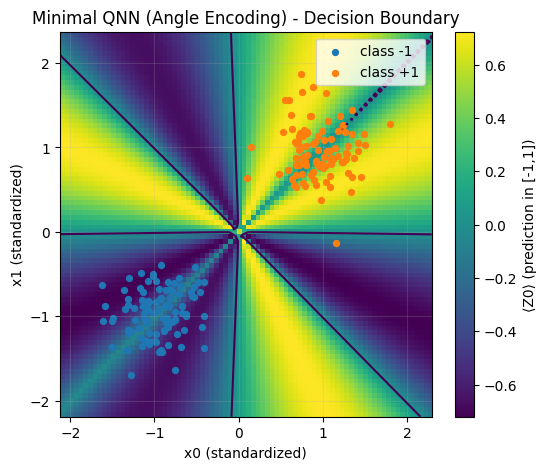

In [31]:
def plot_decision_boundary(X, y, theta, title="Decision boundary"):
    # Grid limits
    x0_min, x0_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    x1_min, x1_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    # Grid
    xs = np.linspace(x0_min, x0_max, 80)
    ys = np.linspace(x1_min, x1_max, 80)
    xx, yy = np.meshgrid(xs, ys)

    # Evaluate model on grid
    grid = np.c_[xx.ravel(), yy.ravel()]
    vals = np.array([predict_value(p, theta) for p in grid], dtype=float)
    zz = vals.reshape(xx.shape)

    plt.figure(figsize=(6, 5))
    im = plt.imshow(
        zz,
        origin="lower",
        extent=[x0_min, x0_max, x1_min, x1_max],
        aspect="auto"
    )
    plt.colorbar(im, label="⟨Z0⟩ (prediction in [-1,1])")

    # Decision boundary at 0
    plt.contour(xx, yy, zz, levels=[0.0])

    # Data points
    plt.scatter(X[y == -1, 0], X[y == -1, 1], s=18, label="class -1")
    plt.scatter(X[y == +1, 0], X[y == +1, 1], s=18, label="class +1")

    plt.xlabel("x0 (standardized)")
    plt.ylabel("x1 (standardized)")
    plt.title(title)
    plt.legend()
    plt.grid(alpha=0.2)
    plt.savefig(RESULTS_DIR / "decision_boundary_angle.png")
    plt.show()

plot_decision_boundary(Xn, y, theta_star, title="Minimal QNN (Angle Encoding) - Decision Boundary")